In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [13]:
import gc
from multiprocessing import Process, Queue

import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

### Basics

In [7]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")}')
    
    
def update_stocks_nc():
    os.system("rm mstncn.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/newconnect/mstock/mstncn.zip")
    #os.system("rm -rf data/*")
    os.system("unzip mstncn.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("CLOUD").index.max().strftime(format = "%Y-%m-%d")}')


def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')


def prepare_data(paper):

    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    try:
        df = store_stocks_dict[paper].copy()
    except:
        df = pd.read_csv(f'data/{paper}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()

    return df


def prepare_index(indeks):

    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')

    try:
        df = store_indexes_dict[indeks].copy()
    except:
        df = pd.read_csv(f'data_for/{indeks}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()

    return df

### Do updates

In [4]:
update_indexes()

Updated 2020-04-26, max actual date:     2020-04-24


In [6]:
update_stocks()

Updated 2020-04-26, max actual date:     2020-04-24


In [8]:
update_stocks_nc()

Updated 2020-04-26, max actual date:     2020-04-24


In [9]:
all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(
    f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}'
)

no of all available stock: 2391 and indexes: 23


In [10]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

watch = ['PZU',
         'AMREST',
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW',
        'INTERCARS',
        'BIOMEDLUB',
        'PKOBP',
        'PEKAO',
        'SUNEX',
        'INTERCARS',
        'WIELTON']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

## Single plot

### Plot code

In [76]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

### Just plot

In [78]:
[a for a in all_stocks if 'CLO' in a]

['RCLOILAOPEN.mst']

In [173]:
papier = 'PKOBP'

In [174]:
#plot_paper(papier,'2008-07-15','2008-11-15')

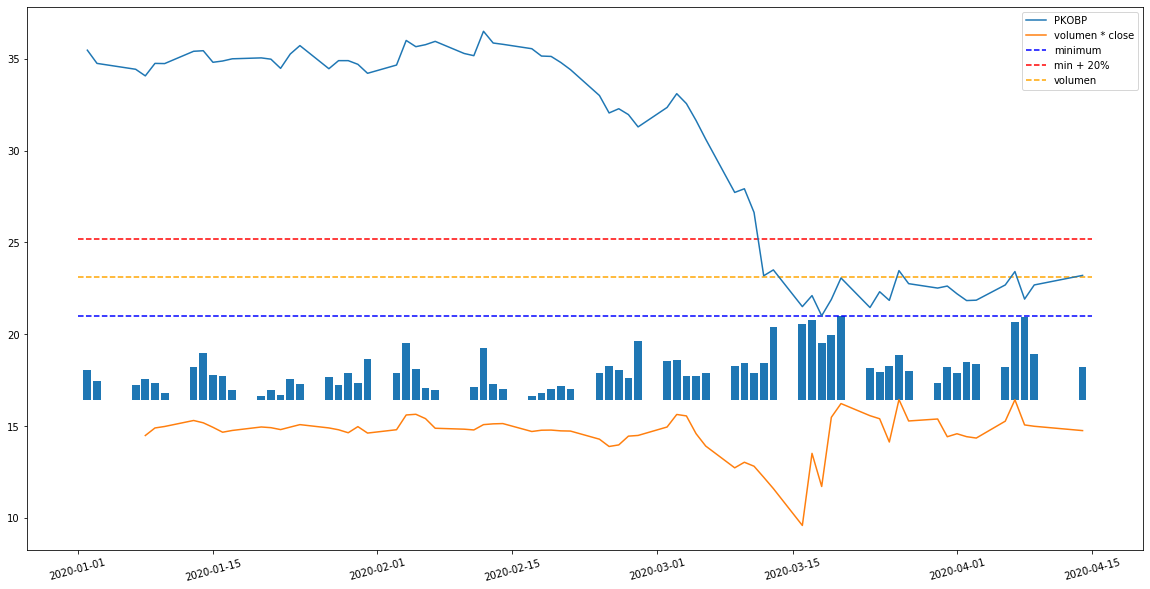

In [175]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [145]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

In [146]:
print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: PLAY, currently at 33.8, with potential 12.43% to top
Max before crisis: 38.0
Crisis bottom: 25.94
Max after crisis drop: 33.8, at 2020-04-09 00:00:00
Stats after Max: [33.8]


## Skaner

In [11]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = [
    'ticker', 'current', 'mean_VOL', 'before_crisis', 'last_y_q', 'last_y_mid',
    'crisis_bottom', 'max_after_crisis', 'max_before_crisis'
]

### All papers

In [12]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index > '2019-10-01' ,'VOL'].mean(),
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

In [14]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [15]:
skaner_df_see = skaner_df.loc[
    #(skaner_df.growth_quarter > 0) 
        #& (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        #(skaner_df.growth_current > -100)
    (skaner_df.mean_VOL > 10000)
                              ,:].sort_values('drop_current', ascending=True)

In [16]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('DVP' in x)
                               | ('RCT' in x)
                               | ('RCS' in x)
                               | ('RCR' in x)
                               | ('RCB' in x)
                               | ('PBSK' in x)
                               | ('RCL' in x) else True).values,]

In [17]:
skaner_df_see.dropna().shape

(251, 15)

In [18]:
skaner_df_see.dropna().head(100)

,ticker,current,mean_VOL,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,ITMTRADE,0.2600,1.816625e+04,1.270,2.2000,2.6000,0.2600,1.0900,2.2000,-42.27,-15.38,319.23,0.00,746.15,-88.18
0,ELBUDOWA,2.0800,1.043192e+05,7.680,6.2600,10.1000,1.2000,5.3000,9.2400,22.68,-38.02,341.67,73.33,344.23,-77.49
0,MABION,23.6000,3.381264e+04,51.100,80.0000,73.5000,17.9600,31.0000,103.6000,-36.12,8.84,72.61,31.40,338.98,-77.22
0,ALTUSTFI,0.6680,5.888046e+04,2.190,1.7200,2.1500,0.6680,1.2500,2.3000,27.33,-20.00,87.13,-0.00,244.31,-70.96
0,BRASTER,0.3500,4.772918e+05,0.370,1.0400,1.7300,0.2000,0.4050,1.1620,-64.42,-39.88,102.50,75.00,232.00,-69.88
0,CCC,43.8000,4.242429e+05,96.500,132.5000,153.9000,24.9800,47.0000,133.0000,-27.17,-13.91,88.15,75.34,203.65,-67.07
0,MOBIMEDIA,0.4000,1.672299e+05,0.725,0.4460,0.1290,0.2460,0.4000,1.2100,62.56,245.74,62.60,62.60,202.50,-66.94
0,SOLAR,3.4100,1.229266e+04,5.800,4.8800,5.1500,2.2000,3.6000,10.3000,18.85,-5.24,63.64,55.00,202.05,-66.89
0,POZBUD,0.8060,4.338735e+04,1.580,1.9100,1.9900,0.6920,1.1900,2.2500,-17.28,-4.02,71.97,16.47,179.16,-64.18
0,COMECO,0.1370,1.015580e+04,0.200,0.3000,0.1600,0.1000,0.1490,0.3800,-33.33,87.50,49.00,37.00,177.37,-63.95


## Model

In [19]:
### ADD WIG20 DAY BEFORE!

def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
#str strike
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5, 10, 20, 30, 60, 120, 240]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).mean()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
            
            df.loc[:,f'comp{i}d_std' + col] = df.loc[:,col].rolling(i).std()
            df.loc[:,f'comp{i}d_std' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_std' + col]) - 100
            
    
#     for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
#         cols = [f'comp{i}d_max' + col for i in [5,10,20]]
#         #df.loc[:,'all_higher_f'] = (df[cols] > 0).sum(axis = 1)
#         df.loc[:,'all_higher_cat'] = (df[cols] > 0).astype(str).sum(axis = 1)
        
#         cols = [f'comp{i}d_min' + col for i in [5,10,20]]
#         #df.loc[:,'all_lower_f'] = (df[cols] < 0).sum(axis = 1)
#         df.loc[:,'all_lower_cat'] = (df[cols] < 0).astype(str).sum(axis = 1)
    
            
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
### HISTORIC SECTION ###

    for a in [c for c in df.columns if ('diff_' in c) | ('chng' in c) | ('chng_' in c)]:
        for i in [1, 2, 3]:
            df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'roll{g}std_' + b] = df.loc[:,b].rolling(g).std()


### SUBTARGET ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'subtarget'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'subtarget'] = 0
            
### TARGET SECTION ###
#pick one the of the available sections

## HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0

### LOWER LOW ###
#     df.loc[df.loc[:, 'LOW'].shift(-1) < df.loc[:, 'LOW'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) >= df.loc[:, 'LOW'],'target'] = 0
    
### HIGHER OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) > df.loc[:, 'OPEN'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1),'target'] = 0

### OPENING NOT FAR FROM LOW ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 > df.loc[:, 'LOW'].shift(-1),'target'] = 0
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 <= df.loc[:, 'LOW'].shift(-1),'target'] = 1
    
### HIGH HIGHER MORE THAN 1% THAN OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 < df.loc[:, 'HIGH'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 >=  df.loc[:, 'HIGH'].shift(-1),'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###

    df.loc[:, 'max_10d'] = df.loc[:, 'CLOSE'].rolling(10).max()
    df.loc[df.loc[:, 'max_10d'].shift(-10) > df.loc[:, 'OPEN'].shift(-1)*1.1,'target'] = 1
    df.loc[df.loc[:, 'max_10d'].shift(-10) <= df.loc[:, 'OPEN'].shift(-1)*1.1,'target'] = 0
    
    return df
#ADD INDEX MEANS!
def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    
    for b in ['chng_OPEN', 'chng_LOW', 'chng_HIGH', 'chng_CLOSE', 'chng_VOL']:    
        for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
            df.loc[:,f'idxroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'idxroll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'idxroll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'idxroll{g}std_' + b] = df.loc[:,b].rolling(g).std()
    return df

In [20]:
def f(q, res):
    while not (q.empty()):
        pap = q.get()
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        df = df.dropna()
        res.put(df)
    #print('done')
    
    
def put_res_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [21]:
q = Queue()
res = Queue()
resfin = Queue()

papers_to_train = list(watch + list(skaner_df_see.dropna().ticker.values))
papers_to_train = list(dict.fromkeys(papers_to_train ))

for w in (papers_to_train):
    q.put(w)

In [22]:
full_size = q.qsize()
total = q.qsize()
pbar = tqdm(total = total)

p = Process(target=f, args=(q, res))
p2 = Process(target=f, args=(q, res))
p3 = Process(target=f, args=(q, res))
p4 = Process(target=f, args=(q, res))
#p5 = Process(target=f, args=(q, res))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


while (res.qsize() != full_size):
    if total > q.qsize():
        pbar.update(1)
        total = q.qsize()
pbar.close()

 98%|█████████▊| 254/258 [04:32<00:04,  1.07s/it]


In [23]:
pt = Process(target=put_res_together, args=(resfin, res))
pt2 = Process(target=put_res_together, args=(resfin, res))
pt3 = Process(target=put_res_together, args=(resfin, res))
pt4 = Process(target=put_res_together, args=(resfin, res))
pt.start()
pt2.start()
pt3.start()
pt4.start()

total = res.qsize()
pbar = tqdm(total = total)

while(res.qsize()):
    if total > res.qsize():
        pbar.update(1)
        total = res.qsize()
pbar.close()

 99%|█████████▉| 255/257 [00:09<00:00, 26.72it/s]


In [24]:
df_merged = pd.DataFrame()

total = resfin.qsize()
pbar = tqdm(total = total)

while not resfin.empty():
    df = resfin.get()
    df_merged = pd.concat([df_merged, df])
    pbar.update(1)
pbar.close()

100%|██████████| 24/24 [00:15<00:00,  1.56it/s]


In [25]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

pt.terminate()
pt2.terminate()
pt3.terminate()
pt4.terminate()


gc.collect()

146

In [26]:
df_indexes_merged = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
    df = transform_one_index(df) 
    
    #df = df.dropna()
    
    df_indexes_merged = pd.concat([df_indexes_merged, df])
    del df

100%|██████████| 23/23 [00:18<00:00,  1.27it/s]


In [27]:
df_indexes_merged.reset_index().head()

,DTYYYYMMDD,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,idxroll80max_chng_VOL,idxroll80std_chng_VOL,idxroll120m_chng_VOL,idxroll120min_chng_VOL,idxroll120max_chng_VOL,idxroll120std_chng_VOL,idxroll240m_chng_VOL,idxroll240min_chng_VOL,idxroll240max_chng_VOL,idxroll240std_chng_VOL
0,1989-10-31,ALL_ORD,1646.3,1646.3,1646.3,1646.3,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1989-11-01,ALL_ORD,1648.7,1648.7,1648.7,1648.7,0,1646.3,0.145781,1646.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1989-11-02,ALL_ORD,1652.2,1652.2,1652.2,1652.2,0,1648.7,0.212288,1648.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1989-11-03,ALL_ORD,1656.9,1656.9,1656.9,1656.9,0,1652.2,0.284469,1652.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1989-11-06,ALL_ORD,1656.9,1656.9,1656.9,1656.9,0,1656.9,0.000000,1656.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df_indexes_merged = df_indexes_merged.reset_index().groupby('DTYYYYMMDD').mean()
df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

idx_cols_chng = [c for c in df_indexes_merged.columns if 'chng' in c]

df_indexes_merged = df_indexes_merged.loc[:,idx_cols_chng]

df_indexes_merged = df_indexes_merged.dropna(how = 'all',axis = 1)

In [29]:
# df_indexes_merged = df_indexes_merged.pivot_table(index='DTYYYYMMDD', columns='TICKER', values='chng_CLOSE')
# df_indexes_merged = df_indexes_merged.agg(['mean', 'max', 'min', 'std'], axis = 1)
# df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

In [30]:
#df_merged = df_merged.drop([c for c in df_merged.columns if 'foreign_s' in c], axis = 1).copy()

In [31]:
df_merged = df_merged.merge(df_indexes_merged, left_index=True, right_index=True, how = 'left')

In [32]:
train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c) | ('hist' in c)]

#train_cols = train_cols + list(df_indexes_merged.columns)

#train_cols = ['all_lower_cat', 'all_higher_cat'] + train_cols

In [33]:
#train_cols = train_cols_limited

df = df_merged.copy()
#df = df.loc[df.index > '2007-01-01',:]

In [34]:
valid = df.loc[df.index >= '2020-03-01'].copy()

In [35]:
df = df.loc[df.index < '2020-03-01']

In [36]:
cut_date = '2019-11-01'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [37]:
def get_model():
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.05,
                           depth=3,
                          thread_count=4,
                          eval_metric='AUC',
                          task_type='CPU')
    return model

In [38]:
model = get_model()

In [39]:
model.fit(train_data, train_labels, #cat_features=[0, 1],
          eval_set=[(train_data[:-1], train_labels[:-1]),(eval_data[:-1], eval_labels[:-1])],
         early_stopping_rounds=100, use_best_model=True)

0:	test: 0.7118453	test1: 0.7147102	best: 0.7147102 (0)	total: 494ms	remaining: 1h 22m 17s
1:	test: 0.7210227	test1: 0.7218814	best: 0.7218814 (1)	total: 914ms	remaining: 1h 16m 7s
2:	test: 0.7276303	test1: 0.7235074	best: 0.7235074 (2)	total: 1.34s	remaining: 1h 14m 29s
3:	test: 0.7309014	test1: 0.7258825	best: 0.7258825 (3)	total: 1.78s	remaining: 1h 14m 22s
4:	test: 0.7321135	test1: 0.7262154	best: 0.7262154 (4)	total: 2.3s	remaining: 1h 16m 47s
5:	test: 0.7331176	test1: 0.7307326	best: 0.7307326 (5)	total: 2.72s	remaining: 1h 15m 30s
6:	test: 0.7339866	test1: 0.7315120	best: 0.7315120 (6)	total: 3.18s	remaining: 1h 15m 39s
7:	test: 0.7343224	test1: 0.7317234	best: 0.7317234 (7)	total: 3.65s	remaining: 1h 15m 55s
8:	test: 0.7351197	test1: 0.7317458	best: 0.7317458 (8)	total: 4.1s	remaining: 1h 15m 56s
9:	test: 0.7364112	test1: 0.7313278	best: 0.7317458 (8)	total: 4.55s	remaining: 1h 15m 45s
10:	test: 0.7369819	test1: 0.7311714	best: 0.7317458 (8)	total: 4.94s	remaining: 1h 14m 46s
1

89:	test: 0.7516288	test1: 0.7384704	best: 0.7384704 (89)	total: 38.4s	remaining: 1h 10m 29s
90:	test: 0.7518677	test1: 0.7385692	best: 0.7385692 (90)	total: 38.9s	remaining: 1h 10m 31s
91:	test: 0.7519939	test1: 0.7388357	best: 0.7388357 (91)	total: 39.3s	remaining: 1h 10m 36s
92:	test: 0.7521268	test1: 0.7388594	best: 0.7388594 (92)	total: 39.7s	remaining: 1h 10m 33s
93:	test: 0.7522037	test1: 0.7388414	best: 0.7388594 (92)	total: 40.2s	remaining: 1h 10m 31s
94:	test: 0.7523418	test1: 0.7388366	best: 0.7388594 (92)	total: 40.6s	remaining: 1h 10m 37s
95:	test: 0.7524755	test1: 0.7389614	best: 0.7389614 (95)	total: 41s	remaining: 1h 10m 34s
96:	test: 0.7526157	test1: 0.7389773	best: 0.7389773 (96)	total: 41.5s	remaining: 1h 10m 35s
97:	test: 0.7526706	test1: 0.7390811	best: 0.7390811 (97)	total: 41.9s	remaining: 1h 10m 35s
98:	test: 0.7527737	test1: 0.7392616	best: 0.7392616 (98)	total: 42.3s	remaining: 1h 10m 29s
99:	test: 0.7529096	test1: 0.7392336	best: 0.7392616 (98)	total: 42.7s	r

177:	test: 0.7600630	test1: 0.7401339	best: 0.7407966 (157)	total: 1m 14s	remaining: 1h 8m 7s
178:	test: 0.7602493	test1: 0.7404435	best: 0.7407966 (157)	total: 1m 14s	remaining: 1h 8m 14s
179:	test: 0.7603511	test1: 0.7404416	best: 0.7407966 (157)	total: 1m 14s	remaining: 1h 8m 11s
180:	test: 0.7604928	test1: 0.7403417	best: 0.7407966 (157)	total: 1m 15s	remaining: 1h 8m 10s
181:	test: 0.7605647	test1: 0.7404325	best: 0.7407966 (157)	total: 1m 15s	remaining: 1h 8m 12s
182:	test: 0.7605831	test1: 0.7404419	best: 0.7407966 (157)	total: 1m 16s	remaining: 1h 8m 10s
183:	test: 0.7606379	test1: 0.7405016	best: 0.7407966 (157)	total: 1m 16s	remaining: 1h 8m 10s
184:	test: 0.7606827	test1: 0.7404738	best: 0.7407966 (157)	total: 1m 17s	remaining: 1h 8m 5s
185:	test: 0.7607524	test1: 0.7405307	best: 0.7407966 (157)	total: 1m 17s	remaining: 1h 8m 2s
186:	test: 0.7607654	test1: 0.7405150	best: 0.7407966 (157)	total: 1m 17s	remaining: 1h 8m 2s
187:	test: 0.7607962	test1: 0.7404975	best: 0.7407966 

264:	test: 0.7657146	test1: 0.7418498	best: 0.7418540 (263)	total: 1m 49s	remaining: 1h 7m 5s
265:	test: 0.7657825	test1: 0.7418524	best: 0.7418540 (263)	total: 1m 49s	remaining: 1h 7m 2s
266:	test: 0.7658878	test1: 0.7418642	best: 0.7418642 (266)	total: 1m 50s	remaining: 1h 7m 3s
267:	test: 0.7659195	test1: 0.7418188	best: 0.7418642 (266)	total: 1m 50s	remaining: 1h 7m 3s
268:	test: 0.7659430	test1: 0.7418198	best: 0.7418642 (266)	total: 1m 51s	remaining: 1h 7m 2s
269:	test: 0.7659574	test1: 0.7418197	best: 0.7418642 (266)	total: 1m 51s	remaining: 1h 6m 58s
270:	test: 0.7659963	test1: 0.7417889	best: 0.7418642 (266)	total: 1m 51s	remaining: 1h 6m 53s
271:	test: 0.7661016	test1: 0.7417889	best: 0.7418642 (266)	total: 1m 52s	remaining: 1h 6m 50s
272:	test: 0.7662667	test1: 0.7416773	best: 0.7418642 (266)	total: 1m 52s	remaining: 1h 6m 52s
273:	test: 0.7663719	test1: 0.7417389	best: 0.7418642 (266)	total: 1m 53s	remaining: 1h 6m 53s
274:	test: 0.7664070	test1: 0.7417545	best: 0.7418642 (

351:	test: 0.7703946	test1: 0.7431848	best: 0.7435889 (332)	total: 2m 23s	remaining: 1h 5m 45s
352:	test: 0.7704190	test1: 0.7432554	best: 0.7435889 (332)	total: 2m 24s	remaining: 1h 5m 44s
353:	test: 0.7704663	test1: 0.7433673	best: 0.7435889 (332)	total: 2m 24s	remaining: 1h 5m 43s
354:	test: 0.7704958	test1: 0.7434160	best: 0.7435889 (332)	total: 2m 25s	remaining: 1h 5m 44s
355:	test: 0.7705550	test1: 0.7435299	best: 0.7435889 (332)	total: 2m 25s	remaining: 1h 5m 43s
356:	test: 0.7705699	test1: 0.7435423	best: 0.7435889 (332)	total: 2m 25s	remaining: 1h 5m 41s
357:	test: 0.7705947	test1: 0.7435323	best: 0.7435889 (332)	total: 2m 26s	remaining: 1h 5m 39s
358:	test: 0.7706227	test1: 0.7435596	best: 0.7435889 (332)	total: 2m 26s	remaining: 1h 5m 37s
359:	test: 0.7706746	test1: 0.7435348	best: 0.7435889 (332)	total: 2m 26s	remaining: 1h 5m 35s
360:	test: 0.7707085	test1: 0.7435348	best: 0.7435889 (332)	total: 2m 27s	remaining: 1h 5m 33s
361:	test: 0.7707472	test1: 0.7435321	best: 0.7435

In [40]:
model.get_feature_importance(prettified=True).head(50)

,Feature Id,Importances
0,roll240std_chng_HIGH,9.211771
1,roll120std_chng_HIGH,8.266013
2,roll240std_chng_OPEN,5.217238
3,roll80std_chng_HIGH,3.278909
4,roll120std_chng_LOW,2.465430
5,roll240max_chng_HIGH,2.269727
6,foreign_stocks_idxroll80max_chng_LOW,2.089414
7,roll240std_chng_CLOSE,2.053024
8,roll40std_chng_HIGH,1.809520
9,foreign_stocks_idxroll40max_chng_OPEN,1.575016


In [41]:
working_feats_785_on_high = ['diff_HIGH_CLOSE', 'diff_OPEN_CLOSE','roll20min_diff_LOW_HIGH',
                     'chng_HIGH','roll2std_chng_HIGH',
                     'comp5d_stdHIGH','roll20min_chng_VOL','comp5d_meanOPEN','move_strength_abs',
                     'roll2min_chng_HIGH','roll3min_move_strength_abs']

imp = model.get_feature_importance(prettified=True)
train_cols_limited  = [c for c in train_cols if c in imp.loc[imp.Importances >= 0.01, 'Feature Id'].values]
#train_cols_limited = working_feats_785_on_high
len(train_cols) - len(train_cols_limited)

421

#### Analysis categorical

In [42]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

preds = preds_class[:-1].astype(int)

In [57]:
preds = preds_proba[:,1].copy()

preds[preds > 0.6] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [58]:
confusion_matrix(eval_labels[:-1].astype(int), preds)

array([[14118,    32],
       [ 3457,    74]])

In [59]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(14118, 32, 3457, 74)

In [60]:
(tn + tp) / (tn + tp + fp + fn)

0.8026695322662746

In [61]:
tp / (tp + fp)

0.6981132075471698

In [62]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.821475,0.178525
1.0,0.691478,0.308522


In [63]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)
df_res_grouped = df_res.drop('zero', axis = 1)

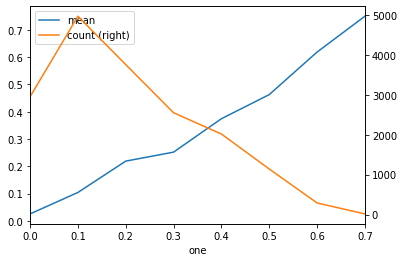

In [64]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [65]:
df_res_grouped

,mean,count
one,,
0.0,0.025432,2949
0.1,0.104129,4965
0.2,0.218966,3754
0.3,0.251863,2549
0.4,0.374318,2017
0.5,0.462752,1141
0.6,0.618557,291
0.7,0.750000,16


### Check valid

In [78]:
valid_data = valid.loc[:,train_cols]
valid_labels = valid.loc[:,'target'].values

preds_class = model.predict(valid_data)
# Get predicted probabilities for each class

preds = preds_class[:-1].astype(int)

In [88]:
preds_proba = model.predict_proba(valid_data)

preds = preds_proba[:,1].copy()

preds[preds > 0.5] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [89]:
confusion_matrix(valid_labels[:-1].astype(int), preds)

array([[3557,  178],
       [2355,  327]])

In [90]:
tn, fp, fn, tp = confusion_matrix(valid_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(3557, 178, 2355, 327)

In [91]:
(tn + tp) / (tn + tp + fp + fn)

0.6052672588436965

In [92]:
tp / (tp + fp)

0.6475247524752475

### Prediction

#### Categorical

In [66]:
eval_data.loc[:,'target'] = eval_labels
eval_data.loc[:,'target'] = eval_data.loc[:,'target']
eval_data.loc[:,'pred_class'] = model.predict(eval_data[train_cols])

eval_data.loc[:,'pred_proba'] = model.predict_proba(eval_data[train_cols])[:,1]
eval_data.loc[:,'pred_proba'] = eval_data.loc[:,'pred_proba'].round(1)

#### Prediction for couple of papers

In [67]:
def transform_results(qpapers, qtransformed, model):
    while not (qpapers.empty()):
        pap = qpapers.get()
        #print(pap)
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        
        df = df.merge(df_indexes_merged,
              left_index=True,
              right_index=True,
              how='left')

        #df.loc[:, 'pred_class'] = model.predict(df[train_cols])
        df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

        df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
        df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
        df.loc[:, 'fut_LOW'] = df.loc[:, 'LOW'].shift(-1)
        df.loc[:, 'fut_HIGH'] = df.loc[:, 'HIGH'].shift(-1)
        
        df.loc[:, 'fut10_CLOSE'] = df.loc[:, 'CLOSE'].shift(-10)
        df.loc[:, 'max_10d'] = df.loc[:, 'CLOSE'].rolling(10).max()
        
        df.loc[:, 'fOPEN_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'fOPEN_fCLOSE_chng'] = (df.loc[:, 'fut_CLOSE'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'CLOSE_fOPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
                                         df.loc[:, 'CLOSE']) - 100
        df.loc[:, 'HIGH_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                         df.loc[:, 'HIGH']) - 100
        df.loc[:, 'LOW_fLOW_chng'] = (df.loc[:, 'fut_LOW'] * 100 /
                 df.loc[:, 'LOW']) - 100
        
        df.loc[:, 'fOPEN_f10CLOSE_chng'] = (df.loc[:, 'fut10_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f10MAX_chng'] = (df.loc[:, 'max_10d'].shift(-10) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
    

        one_res = df.reset_index().loc[:, [
            'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 
           'fut_OPEN', 'fut_LOW', 'fut_HIGH', 'fut_CLOSE', 'fOPEN_fHIGH_chng', 
            'fOPEN_fCLOSE_chng', 'CLOSE_fOPEN_chng', 'HIGH_fHIGH_chng', 'LOW_fLOW_chng', 
            'fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng', 'pred_prob']
                                      ].tail(15)
    
        #if one_res.shape == (15, 16):
        qtransformed.put(one_res)
    
    
def put_res_results_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [68]:
qpapers = Queue()
qtransformed = Queue()

for w in (skaner_df_see.dropna().ticker.values):
    qpapers.put(w)

In [69]:
total = qpapers.qsize()
full_size = qpapers.qsize()

#%%time
p = Process(target=transform_results, args=(qpapers, qtransformed, model))
p2 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p3 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p4 = Process(target=transform_results, args=(qpapers, qtransformed, model))
#p5 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


pbar = tqdm(total = total)

while not qpapers.empty():
    if total > qpapers.qsize():
        pbar.update(1)
        #print(total)
        total = qpapers.qsize()
pbar.close()

 98%|█████████▊| 247/251 [05:06<00:04,  1.24s/it]


In [70]:
qtransformed.qsize()

251

In [71]:
res = pd.DataFrame()
for i in tqdm(range(qtransformed.qsize())):
    df = qtransformed.get()
    #print(df.TICKER.values[0])
    res = pd.concat([res, df])
    #print(res.shape)

100%|██████████| 251/251 [00:00<00:00, 685.38it/s]


In [72]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

In [73]:
res.loc[:,'DTYYYYMMDD'] = pd.to_datetime(res.DTYYYYMMDD)

In [74]:
res.loc[res.DTYYYYMMDD == '2020-04-20'].sort_values('pred_prob', ascending=False).tail(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,fut_OPEN,fut_LOW,fut_HIGH,fut_CLOSE,fOPEN_fHIGH_chng,fOPEN_fCLOSE_chng,CLOSE_fOPEN_chng,HIGH_fHIGH_chng,LOW_fLOW_chng,fOPEN_f10CLOSE_chng,fOPEN_f10MAX_chng,pred_prob
3001,2020-04-20,TRAKCJA,1.4400,1.390,1.4860,1.3900,1.430,1.3000,1.430,1.3240,0.000000e+00,-7.412587,2.877698e+00,-3.768506,-6.474820,NaN,NaN,0.345612
2192,2020-04-20,LIBET,0.9800,0.970,1.0050,1.0000,1.000,1.0000,1.030,1.0000,3.000000e+00,0.000000,0.000000e+00,2.487562,3.092784,NaN,NaN,0.344302
3716,2020-04-20,LOTOS,64.8200,62.720,64.9000,64.3200,62.400,60.2600,63.400,61.7400,1.602564e+00,-1.057692,-2.985075e+00,-2.311248,-3.922194,NaN,NaN,0.344119
1939,2020-04-20,VIVID,1.3500,1.320,1.3760,1.3720,1.390,1.3340,1.400,1.3400,7.194245e-01,-3.597122,1.311953e+00,1.744186,1.060606,NaN,NaN,0.343605
840,2020-04-20,CLNPHARMA,34.5000,33.400,34.5000,34.0000,34.500,31.2000,35.200,32.0000,2.028986e+00,-7.246377,1.470588e+00,2.028986,-6.586826,NaN,NaN,0.342620
1922,2020-04-20,ZAMET,0.8800,0.880,0.9200,0.9200,0.900,0.9000,0.920,0.9200,2.222222e+00,2.222222,-2.173913e+00,0.000000,2.272727,NaN,NaN,0.340878
1235,2020-04-20,WIRTUALNA,68.0000,67.000,72.0000,70.2000,69.600,67.0000,73.600,71.0000,5.747126e+00,2.011494,-8.547009e-01,2.222222,0.000000,NaN,NaN,0.339193
223,2020-04-20,ARTGAMES,2.0500,2.040,2.3400,2.3100,2.350,2.0700,2.350,2.0700,0.000000e+00,-11.914894,1.731602e+00,0.427350,1.470588,NaN,NaN,0.337916
2044,2020-04-20,GETINOBLE,0.2295,0.220,0.2295,0.2275,0.227,0.2165,0.227,0.2185,0.000000e+00,-3.744493,-2.197802e-01,-1.089325,-1.590909,NaN,NaN,0.334637
1499,2020-04-20,LIVECHAT,55.0000,52.400,55.0000,53.5000,54.200,51.8000,54.200,53.8000,0.000000e+00,-0.738007,1.308411e+00,-1.454545,-1.145038,NaN,NaN,0.334417


In [76]:
res.loc[res.DTYYYYMMDD == '2020-04-24'].sort_values('pred_prob', ascending=False).head(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,fut_OPEN,fut_LOW,fut_HIGH,fut_CLOSE,fOPEN_fHIGH_chng,fOPEN_fCLOSE_chng,CLOSE_fOPEN_chng,HIGH_fHIGH_chng,LOW_fLOW_chng,fOPEN_f10CLOSE_chng,fOPEN_f10MAX_chng,pred_prob
1779,2020-04-24,ITMTRADE,0.3000,0.2600,0.3150,0.2600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.589250
1148,2020-04-24,IGORIA,0.2440,0.1960,0.2440,0.2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.549650
2038,2020-04-24,PLGROUP,0.3300,0.3110,0.3340,0.3200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.511017
687,2020-04-24,NESTMEDIC,1.7450,1.5800,1.7700,1.5800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.467824
6694,2020-04-24,MILLENNIUM,2.7980,2.7220,2.8420,2.7220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.460288
1729,2020-04-24,AITON,0.3860,0.3100,0.4000,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.442807
3186,2020-04-24,KOMPUTRON,2.2900,2.2900,2.7600,2.4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.430410
4017,2020-04-24,REDAN,0.2000,0.1980,0.2000,0.1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.427230
467,2020-04-24,CWA,0.4440,0.3840,0.4660,0.3860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.422065
1539,2020-04-24,NFPL,0.3000,0.2980,0.3000,0.2980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.421820


In [98]:
str(date.today())

'2020-04-26'

In [99]:
last_day = res.loc[res.DTYYYYMMDD == '2020-04-23'].sort_values('pred_prob', ascending=False)

In [100]:
last_day.mean()

OPEN                   847.300354
LOW                    840.512366
HIGH                   856.803506
CLOSE                  855.353269
fut_OPEN               864.640588
fut_LOW                857.452621
fut_HIGH               872.777844
fut_CLOSE              862.672394
fOPEN_fHIGH_chng         2.390472
fOPEN_fCLOSE_chng       -0.170594
CLOSE_fOPEN_chng        -0.018308
HIGH_fHIGH_chng         -0.094977
LOW_fLOW_chng            0.418469
fOPEN_f10CLOSE_chng           NaN
fOPEN_f10MAX_chng             NaN
pred_prob                0.322444
dtype: float64

In [102]:
last_day.loc[last_day.pred_prob > 0.5].mean()

OPEN                    0.925667
LOW                     0.747542
HIGH                    0.935250
CLOSE                   0.772250
fut_OPEN                0.835000
fut_LOW                 0.795182
fut_HIGH                0.887000
fut_CLOSE               0.822727
fOPEN_fHIGH_chng        3.033482
fOPEN_fCLOSE_chng      -3.432830
CLOSE_fOPEN_chng        1.722020
HIGH_fHIGH_chng       -10.729307
LOW_fLOW_chng           0.299244
fOPEN_f10CLOSE_chng          NaN
fOPEN_f10MAX_chng            NaN
pred_prob               0.542322
dtype: float64

In [103]:
res_see = res.sort_values('pred_prob', ascending=False).copy()
res_see = res_see.drop_duplicates()
res_see.loc[res_see.pred_prob > 0.5].groupby('DTYYYYMMDD').mean().mean()

OPEN                    2.213165
LOW                     1.992717
HIGH                    2.322677
CLOSE                   2.120233
fut_OPEN                2.177326
fut_LOW                 2.049484
fut_HIGH                2.521977
fut_CLOSE               2.406848
fOPEN_fHIGH_chng        7.248447
fOPEN_fCLOSE_chng       3.423520
CLOSE_fOPEN_chng        0.116136
HIGH_fHIGH_chng        -0.453371
LOW_fLOW_chng           2.465965
fOPEN_f10CLOSE_chng    13.905754
fOPEN_f10MAX_chng      35.839066
pred_prob               0.558501
dtype: float64

In [104]:
res_see.loc[:,'pred_prob_rounded'] = res_see.pred_prob.round(1)

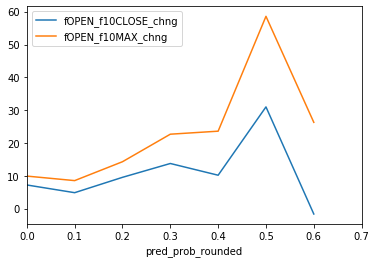

In [105]:
res_see.groupby('pred_prob_rounded').mean()[['fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng']].plot()

In [106]:
res_see.groupby('pred_prob_rounded').mean()[['fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng']]

,fOPEN_f10CLOSE_chng,fOPEN_f10MAX_chng
pred_prob_rounded,,
0.0,7.203735,9.909725
0.1,4.852572,8.531550
0.2,9.531303,14.285624
0.3,13.747935,22.673577
0.4,10.173911,23.593901
0.5,30.988490,58.583630
0.6,-1.644592,26.286438
0.7,NaN,NaN


## Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
